In [4]:
# creating PIPLELINE
# __author__ == shubham0704

# dependencies
import numpy as np
from PIL import Image
from scipy import ndimage

**Load datasets**

Images will be loaded into train and test data set and will be converted to gray scale

In [5]:
import glob
import os

def label_getter(file_name):
    
    labels = []
    for file in os.listdir(file_name):
        print(file_name+file)
        inner_files_regex = file_name + file + '/*.jpeg'
        labels.append(glob.glob(inner_files_regex))
    return labels

In [6]:
train_folder_labels = label_getter('./TARGETS/TRAIN/')
test_folder_labels = label_getter('./TARGETS/TEST/')
print(len(train_folder_labels))
print(len(test_folder_labels))

./TARGETS/TRAIN/BMP2
./TARGETS/TRAIN/T72
./TARGETS/TRAIN/BTR70
./TARGETS/TEST/BMP2
./TARGETS/TEST/T72
./TARGETS/TEST/BTR70
3
3


**A sample file looks like -**

(128, 128)


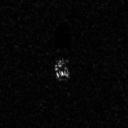

In [7]:
img = Image.open(train_folder_labels[0][0])
print(img.size)
image_size = img.size[0]
img

---
**Create pickle of all files**

Pickling these files will help to load it on demand

+ Load files into memory and create real file data set

In [8]:
import pickle

pixel_depth = 255
# Note - dividing by pixel depth distrubutes these values around 0. So uniform variance and 0 mean
print(image_size)
# create datasets
def load_tank_type(image_labels):
    images = image_labels
    print(len(images))
    dataset = np.ndarray(shape=(len(images), image_size, image_size),
                         dtype=np.float32)
    for index,image in enumerate(images):
        image_path = image
        image_data = (ndimage.imread(image_path).astype(float) - 
                    pixel_depth / 2) / pixel_depth
        #image_data = ndimage.imread(image_path)
        dataset[index,:,:] = image_data
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def pickle_files(folder_labels, folder_type, force=False):
    tank_names = ['BMP2','T72','BTR70']
    dataset_names = []
    for index,name in enumerate(tank_names):
        set_filename = folder_type + '_' + name + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
          # You may override by setting force=True.
          print('%s already present - Skipping pickling.' % set_filename)
        else:
          print('Pickling %s.' % set_filename)
          dataset = load_tank_type(folder_labels[index])
          try:
            with open(set_filename, 'wb') as f:
              pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
          except Exception as e:
            print('Unable to save data to', set_filename, ':', e)
    return dataset_names

train_dataset = pickle_files(train_folder_labels,'TRAIN')
test_dataset = pickle_files(test_folder_labels,'TEST')

128
TRAIN_BMP2.pickle already present - Skipping pickling.
TRAIN_T72.pickle already present - Skipping pickling.
TRAIN_BTR70.pickle already present - Skipping pickling.
TEST_BMP2.pickle already present - Skipping pickling.
TEST_T72.pickle already present - Skipping pickling.
TEST_BTR70.pickle already present - Skipping pickling.


---
**Spot check to see if the file still looks good**

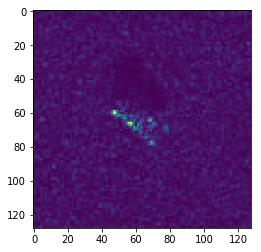

In [9]:
import matplotlib.pyplot as plt

pickle_file = train_dataset[0]
with open(pickle_file, 'rb') as file:
    tank_set = pickle.load(file)
    sample_image = tank_set[5,:,:]
    plt.figure()
    plt.imshow(sample_image)
    plt.show()

In [16]:
# we need to merge datasets for training in order to train well
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        tank_set = pickle.load(f)
        # let's shuffle the tank_type to have random validation and training set
        np.random.shuffle(tank_set)
        if valid_dataset is not None:
          valid_tank = tank_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_tank
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_tank = tank_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_tank
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels

In [27]:
# pass test data first and then I will pass train data
# break test into validation and test data set
import math
valid_dataset, valid_labels, test_dataset, test_labels = merge_datasets(
                                                                    test_dataset,math.floor(0.7*195)*3,
                                                                    math.floor(0.3*195)*3)
_, _, train_dataset, train_labels = merge_datasets(train_dataset,232*3)

In [29]:
print(len(valid_dataset))
print(len(test_dataset))
print(len(train_dataset))
print(valid_labels[:5])

174
408
696
[0 0 0 0 0]


As we can see labels are not shuffled so lets shuffle labels accordingly

In [30]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Finally lets save data for further reuse - 

In [33]:
pickle_file = os.path.join(os.getcwd(), 'final_dataset.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [34]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 83760617


Next step is to use it in a Fuzzy Neural Network